In [1]:
import numpy as np
import subprocess
import time
import copy
from utils.opt_utils import *
import os
import h5py
import pickle
from qutip import *
import json

In [2]:
with open("../../utils/pulse_configs.py") as f:
    data = f.read()

config_dict = json.loads(data)

print(type(config_dict))
print(type(dict(config_dict)))

# config_dict["test"] = 1
# print(config_dict["test"])

<class 'dict'>
<class 'dict'>


In [3]:
# Defining relevant values
q_ch = config_dict["qubit"]["ch"] 
A_ch = config_dict["storage_A"]["ch"]
B_ch = config_dict["storage_B"]["ch"]

wq = config_dict["qubit"]["freqs"]["g"]["ge"]
wa_A = config_dict["storage_A"]["freq"]
wa_B = config_dict["storage_B"]["freq"]

In [4]:
# ========== OPTIONS ========== #
max_segs = 1000
us = 0.000001
time_start = 0 * us
time_stop = 1.00 * us
init_qamp = 2000
init_camp = 4000

num_drives = 2
chs = [2, 4]
init_freqs = [wq, wa_A]
verbose = True
plot_opt_pulses = True
plot_pulse_viewer = True
start_split_num = 200
n_seg_jump = 1
load_trial_pulses = True

load_pulse_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\exp_1g_interp_amp'
load_times_file = r'opt_SNAP_times_1g.txt'
load_amps_file = r'opt_SNAP_amps_1g.txt'
use_loaded_data = False

save_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\exp_1g_interp_amp\save_data'
hdf5_name = time.strftime('50pts-%Y%m%d-%H%M%S.h5')
epochs = 1000000
epochs_per_seg = 50
train_batch_size = 20
qubit_amp_scale = 0
cavity_amp_scale = 0
# ========== OPTIONS ========== #

qscale = []
cscale = []
for i in range(2 * start_split_num):
    qscale.append(init_qamp * qubit_amp_scale)
    cscale.append(init_camp * cavity_amp_scale)

drive_freqs = np.array(init_freqs)

# Setup initial times and pulse amplitudes
times = np.linspace(time_start, time_stop, start_split_num + 2)

t_segs = np.array([times[1:-1] for i in range(2 * num_drives)])

In [5]:
# new pulse setup
if load_trial_pulses:
    def gauss(A, mu, sigma, C=0):
        def ret_gauss(x):
            # zo_mask1 = (mu + (2 * sigma)) < x
            # zo_mask2 = x < (mu - (2 * sigma))
            # zo_mask = 1 - zo_mask1 - zo_mask2
            def x_map(y):
                if((y >= (mu - (2 * sigma))) and (y <= (mu + (2 * sigma)))):
                    return A * np.exp(-np.power(y - mu, 2) / (np.power(sigma, 2))) + C
                return 0
            r = list(map(x_map, x))
            return r
        return ret_gauss
    
    def func_add(func1, func2):
        def added_funcs(x):
            return np.array(func1(x)) + np.array(func2(x))
        return added_funcs
    
    def zeros(x):
        return x - x
    
    def ones(x):
        return (x + 1) - x
    
    # qubit
    q_pi_amp = 3760
    q_pi_sigma = 0.19 * us
    q_pi_mu = 0.50 * us
    
    #cavity
    disp_amp_1 = 14500
    disp_sigma_1 = 0.03 * us
    disp_mu_1 = 0.06 * us
    
    disp_amp_2 = -8500
    disp_sigma_2 = 0.03 * us
    disp_mu_2 = 0.94 * us
    
    qubit_pulse_func = gauss(q_pi_amp, q_pi_mu, q_pi_sigma)
    cavity_pulse_func = func_add(
        gauss(disp_amp_1, disp_mu_1, disp_sigma_1),
        gauss(disp_amp_2, disp_mu_2, disp_sigma_2)
    )
    
    amp_segs = np.array([
        qubit_pulse_func(times)[1:-1],
        ones(times)[1:-1],
        cavity_pulse_func(times)[1:-1],
        ones(times)[1:-1]]
    )
else:
    amp_segs = (2 * np.round(np.random.rand(2 * num_drives, start_split_num))) - 1
    amp_segs[:2, :] *= init_qamp
    amp_segs[2:, :] *= init_camp
    
    # if use_loaded_data:
    #     print("Loading data")
    #     load_pulse_times = np.loadtxt(str(os.path.join(load_pulse_dir, load_times_file)))
    #     load_pulse_amps = np.loadtxt(str(os.path.join(load_pulse_dir, load_amps_file)))
    #     
    #     t_segs = np.array(load_pulse_times)
    #     amp_segs = np.array(load_pulse_amps)
    
    # print(f'amp_segs: {amp_segs}')
    # print(f'np.shape(amp_segs): {np.shape(amp_segs)}')
    # print(f't_segs: {t_segs}')
    # print(f'np.shape(t_segs): {np.shape(t_segs)}')
    
    # Create blank history arrays for storing optimal / past values
    time_hist = []
    amp_hist = []
    cost_hist = []

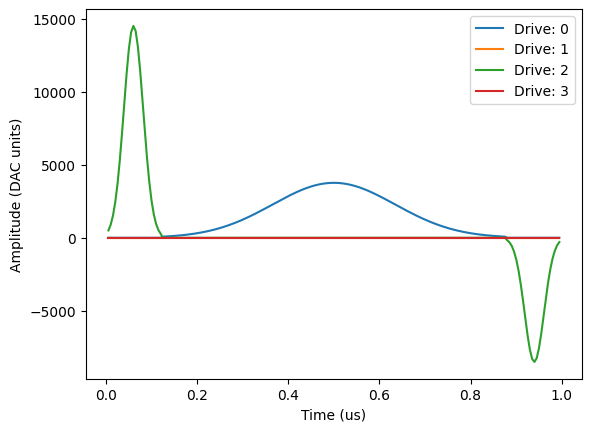

In [6]:
for i in range(len(amp_segs)):
    plt.plot(times[1:-1] / us, amp_segs[i], label=f'Drive: {i}')
plt.legend()
plt.xlabel("Time (us)")
plt.ylabel("Amplitude (DAC units)")
plt.show()

In [ ]:
# Run vqe, etc
vmax = np.vectorize(max)
vmin = np.vectorize(min)

hdf5_start_index = 0
start_segs = start_split_num
for i in range(max_segs):
    
    temp_amp_scale = np.append(np.array(qscale), np.array(cscale))
    client_args = [chs, verbose, plot_opt_pulses, plot_pulse_viewer, time_start, time_stop, drive_freqs, t_segs.flatten()]
    server_args = [epochs, train_batch_size, amp_segs, temp_amp_scale, hdf5_name]

    # Save args for rl client
    cf_name = "temp_files/client_args.txt"
    with open(cf_name, "wb") as fp:
        pickle.dump(client_args, fp)
    fp.close()

    # Save args for rl server
    sf_name = "temp_files/server_args.txt"
    with open(sf_name, "wb") as fp:
        pickle.dump(server_args, fp)
    fp.close()


    os.system('cmd /c python ./run_rl_scripts.py')

    # Give time for files to be updated etc
    time.sleep(1)

    time.sleep(10)
    opt_amps = []
    opt_times = []
    opt_freqs = []

    with h5py.File(os.path.join(save_dir, hdf5_name), "r") as f:
        opt_res_index = np.argmax(f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()])
        opt_result = f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()][opt_res_index]
        for j in range(2 * num_drives):
            opt_amps.append([f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'pulse_array_{j}'][()][opt_res_index]])
        
    # updates amplitudes and frequencies with optimized values and reshape
    amp_segs = np.array(opt_amps)
    amp_segs = np.reshape(amp_segs, (num_drives * 2, int(len(amp_segs.flatten()) / (num_drives * 2))))

    print(f'================')
    print(f'num segs: {i + start_segs} ')
    print(f'opt_amps: {amp_segs}')
    print(f'opt_result: {opt_result}')

    # save values to history arrays
    time_hist.append(interp_time_wrapper(t_segs, time_start, time_stop))
    amp_hist.append(interp_amp_wrapper(amp_segs))
    cost_hist.append(opt_result)

    np.savez(r'run_data\\' + hdf5_name[:-3] + "-" + str(i) + ".npz", time=time_hist[-1], amp=amp_hist[-1], cost=cost_hist[-1])

    for i in range(2 * n_seg_jump):
        qscale.append(init_qamp * qubit_amp_scale)
        cscale.append(init_camp * cavity_amp_scale)

    # split segments and return to start of loop
    if (i < max_segs - 1):
        for i in range(n_seg_jump):
            t_segs, amp_segs = split_segs_flat(interp_time_wrapper(t_segs, time_start, time_stop), interp_amp_wrapper(amp_segs))